In [1]:
import intake
import os.path
import xarray as xr
from utils import plotter
from analogs import calculate_analogs, load_LENS_dataset, print_analog_stats, plot_analog_validation
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
import cartopy

In [2]:
# lat, lon = 33.1072795,35.4688208
lat, lon = 20.194824,-100.9225607

In [ ]:
URL = "/home/jhexr/code/clustering_analogs/data/aws-cesm1-le.json"
if not os.path.isfile(URL):
    URL = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/\
        catalogs/aws-cesm1-le.json"

In [ ]:
#LENS_dataset = load_LENS_dataset(URL)
#LENS_dataset.to_netcdf("./data/Lens_dataset.nc")
LENS_dataset = xr.open_dataset('./data/Lens_dataset.nc')
print(LENS_dataset)

In [ ]:
curr_analogs = calculate_analogs(
    LENS_dataset, lat, lon, 
    ['TREFHT', 'PRECC'], LENS_dataset, 
    '2000-01-01', '2009-12-31', 
    '2000-01-01', '2009-12-31')

In [ ]:
curr_analogs = curr_analogs.load()
print("Done")
print(curr_analogs)

In [56]:
curr_analogs = xr.load_dataset('./data/gto_cesm.nc')
curr_distances = curr_analogs['Standardized Euclidean Distance'].mean(dim='member_id')
da = curr_distances
cmap = 'Greens_r'
title = 'Current Climate Analogs for 2000-2009 Hula'
vmin = 0
vmax = 3
k = 3
location=(lon,lat)
mask_out_ocean = True
cbar_ylabel=None

In [57]:
# mask ocean
if mask_out_ocean:
    import xesmf as xe
    ds_in = xr.open_dataset("./data/lsmask.oisst.v2.nc")
    regridder = xe.Regridder(ds_in, da, 'nearest_s2d', reuse_weights=True)
    ds_in = regridder(ds_in).squeeze()
    da.values[ds_in['lsmask'] == 1] = np.nan

Reuse existing file: nearest_s2d_720x1440_192x288.nc
using dimensions (&#39;lat&#39;, &#39;lon&#39;) from data variable lsmask as the horizontal dimensions for this dataset.


In [58]:
#get top locations, substitute for kmeans
da_min = da.where(da != da.sel(lat=lat, lon=lon, method='nearest'))

df = da_min.to_dataframe().dropna()
print(df)

points = []
for _ in range(k):
    points.append(da_min.where(da_min==da_min.min(), drop=True).squeeze())
    da_min = da_min.where(da_min!=da_min.min(), drop=True).squeeze()
print("\npoints:")
print(points)
top_k=[(p.lon.item(), p.lat.item()) for p in points]

                   Standardized Euclidean Distance
lat        lon                                    
-90.000000 0.00                          36.365845
           1.25                          36.285984
           2.50                          36.281197
           3.75                          36.278149
           5.00                          36.366158
...                                            ...
 83.403145 327.50                        23.556850
           328.75                        23.543150
           330.00                        23.494827
           331.25                        23.432343
           332.50                        23.290562

[18478 rows x 1 columns]

points:
[&lt;xarray.DataArray &#39;Standardized Euclidean Distance&#39; ()&gt;
array(0.40475354, dtype=float32)
Coordinates:
    lat      float64 20.26
    lon      float64 6.25, &lt;xarray.DataArray &#39;Standardized Euclidean Distance&#39; ()&gt;
array(0.4085949, dtype=float32)
Coordinates:
    lat      flo

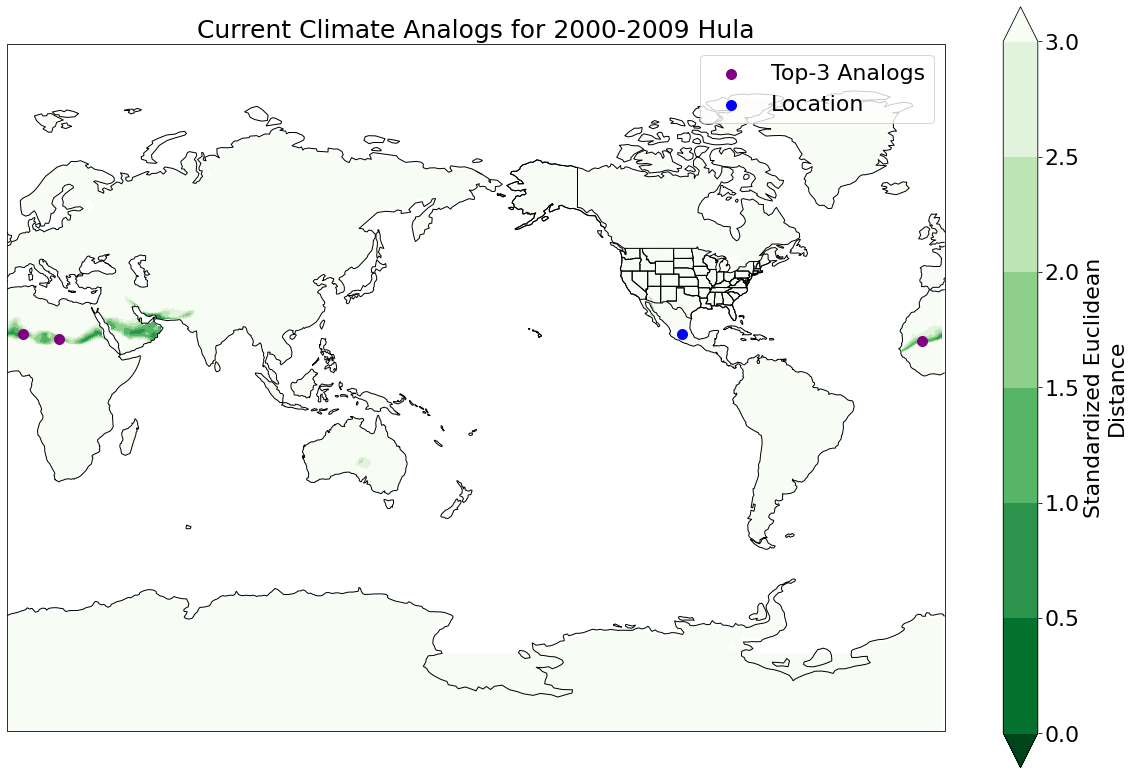

[(6.25, 20.2617797851562), (20.0, 18.3769626617432), (351.25, 17.4345550537109)]


In [59]:
# plot
plt.figure(figsize=(21,14))
ax = plt.axes(projection=ccrs.Miller(central_longitude=180))
contours = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
if cbar_ylabel:
    contours.colorbar.ax.set_ylabel(cbar_ylabel)
plt.title(title, size=25)
ax.set_global(); ax.coastlines(); ax.add_feature(cartopy.feature.STATES)

#plot points
if top_k:  
    ax.scatter([a[0] for a in top_k],[a[1] for a in top_k],
    transform=ccrs.PlateCarree(), color='purple',
    s=100, label = "Top-{} Analogs".format(k))
ax.scatter(*(location), transform=ccrs.PlateCarree(),
    color='blue', s=100, label="Location")
ax.legend()
plt.show()
print (top_k)